In [ ]:
#Providing Access to Google drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ARIMA(0, 0, 1) RMSE = 0.0042
ARIMA(0, 0, 2) RMSE = 0.0041
ARIMA(0, 0, 3) RMSE = 0.0041
ARIMA(0, 0, 4) RMSE = 0.0042
ARIMA(0, 0, 5) RMSE = 0.0042
ARIMA(0, 0, 6) RMSE = 0.0040
ARIMA(1, 0, 0) RMSE = 0.0041
ARIMA(1, 0, 1) RMSE = 0.0041
ARIMA(1, 0, 2) RMSE = 0.0039
ARIMA(1, 0, 3) RMSE = 0.0040
ARIMA(1, 0, 4) RMSE = 0.0035
ARIMA(1, 0, 5) RMSE = 0.0041
ARIMA(1, 0, 6) RMSE = 0.0028
ARIMA(2, 0, 0) RMSE = 0.0041
ARIMA(2, 0, 1) RMSE = 0.0041
ARIMA(2, 0, 2) RMSE = 0.0040
ARIMA(2, 0, 3) RMSE = 0.0038
ARIMA(2, 0, 4) RMSE = 0.0027
ARIMA(2, 0, 5) RMSE = 0.0041
ARIMA(2, 0, 6) RMSE = 0.0032
ARIMA(3, 0, 0) RMSE = 0.0040
ARIMA(3, 0, 1) RMSE = 0.0041
ARIMA(3, 0, 2) RMSE = 0.0040
ARIMA(3, 0, 3) RMSE = 0.0039
ARIMA(3, 0, 4) RMSE = 0.0027
ARIMA(3, 0, 5) RMSE = 0.0041
ARIMA(3, 0, 6) RMSE = 0.0033
ARIMA(4, 0, 0) RMSE = 0.0040
ARIMA(4, 0, 1) RMSE = 0.0040
ARIMA(4, 0, 2) RMSE = 0.0040
ARIMA(4, 0, 3) RMSE = 0.0039
ARIMA(4, 0, 4) RMSE = 0.0041
ARIMA(4, 0, 5) RMSE = 0.0041
ARIMA(4, 0, 6) RMSE = 0.0075
ARIMA(5, 0, 0)

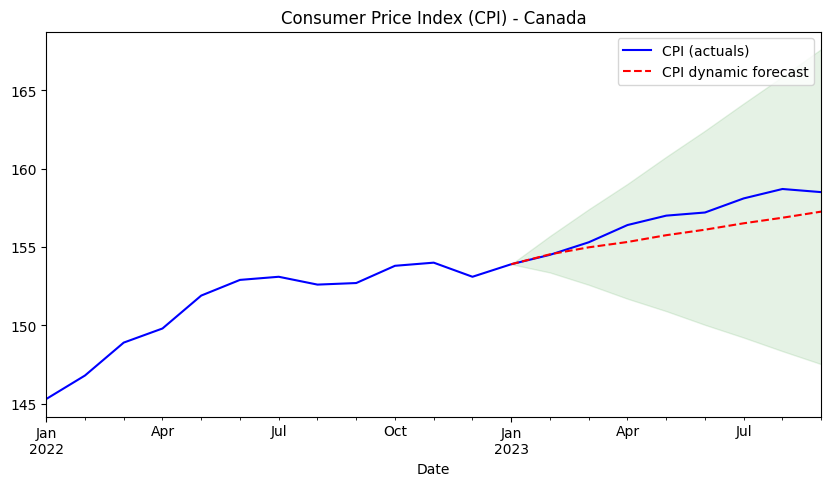

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

# Define a function for date parsing
def date_parser(dates):
    return pd.to_datetime(dates, format='%d/%m/%Y')

# Load and preprocess data
def load_and_preprocess_data(cpi_csv_path, cpi_weights_csv_path):
    cpi_cad = pd.read_csv(cpi_csv_path, parse_dates=['Date'], index_col='Date', date_parser=date_parser)
    cpi_weights = pd.read_csv(cpi_weights_csv_path, parse_dates=['Date'], index_col='Date', date_parser=date_parser)

    column_mapping = {
        'All-items': 'cpi',
        'Food': 'food',
        'Shelter': 'shelter',
        'Household operations, furnishings and equipment': 'household',
        'Clothing and footwear': 'clothing',
        'Transportation': 'transportation',
        'Health and personal care': 'health',
        'Recreation, education and reading': 'recreation',
        'Alcoholic beverages, tobacco products and recreational cannabis': 'alcohol'
    }
    cpi_cad.rename(columns=column_mapping, inplace=True)
    cpi_weights.rename(columns=column_mapping, inplace=True)

    # Create log and differenced log columns using vectorized operations
    columns_to_process = ['cpi', 'food', 'shelter', 'household', 'clothing', 'transportation', 'health', 'recreation', 'alcohol']
    cpi_cad[[f'log{column}' for column in columns_to_process]] = np.log(cpi_cad[columns_to_process] + 1e-10)
    cpi_cad[[f'dlog{column}' for column in columns_to_process]] = cpi_cad[[f'log{column}' for column in columns_to_process]].diff()

    return cpi_cad, cpi_weights

# Load and preprocess the data
# Statistics Canada
# https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000401
cpi_csv_path = '/content/drive/MyDrive/ .... /CPI_CAD_20231018.csv'
# Basket weights of the Consumer Price Index, Canada
# https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000701
cpi_weights_csv_path = '/content/drive/MyDrive/ .... /CPI_CAD_Weights_2021_2022.csv'
cpi_cad, cpi_weights = load_and_preprocess_data(cpi_csv_path, cpi_weights_csv_path)

# Define a function for ARIMA model evaluation
def arima_model_evaluate(actuals, validation, order):
    sarimax_model = SARIMAX(actuals, order=order).fit()
    prediction = sarimax_model.get_forecast(len(validation))
    predictions_df = prediction.conf_int(alpha=0.9)
    predictions_df["Predictions"] = sarimax_model.predict(start=predictions_df.index[0], end=predictions_df.index[-1])
    predictions_df.index = validation.index
    predictions_arima = predictions_df["Predictions"]
    rmse_score = rmse(validation, predictions_df["Predictions"])
    return rmse_score

# Define a function to optimize ARIMA model parameters
def optimize_arima(actuals, validation, p_values, d_values, q_values):
    best_rmse, best_config = float("inf"), None
    parameter_combinations = [(p, d, q) for p in p_values for d in d_values for q in q_values]
    for order in parameter_combinations:
        rmse_score = arima_model_evaluate(actuals, validation, order)
        if order == (0, 0, 0):
            continue
        elif rmse_score < best_rmse:
            best_rmse, best_config = rmse_score, order
        print(f'ARIMA{order} RMSE = {rmse_score:.4f}')
    print(f'Best Configuration: ARIMA{best_config}, RMSE = {best_rmse:.4f}')
    return best_config

# Train ARIMA model and get best configuration
t = 8
cpi_cad_train = cpi_cad.iloc[:-t]
cpi_cad_validation = cpi_cad.iloc[-t:]
actuals = cpi_cad_train['dlogcpi'].dropna()
validation = cpi_cad_validation['dlogcpi'].dropna()
p_values = range(0, 7)
d_values = range(0, 1)
q_values = range(0, 7)
best_config = optimize_arima(actuals, validation, p_values, d_values, q_values)
order = best_config

# Train the final ARIMA model with the best configuration
sarimax_model = SARIMAX(actuals, order=order).fit()
prediction = sarimax_model.get_forecast(len(validation))
predictions_df = prediction.conf_int()
predictions_df["Predictions"] = sarimax_model.predict(start=predictions_df.index[0], end=predictions_df.index[-1])
predictions_df.index = validation.index

# Combine forecasted columns in the original DataFrame
cpi_cad['cpipred_m'] = predictions_df['Predictions']
cpi_cad['logcpipred_m'] = np.nan
for i in range(t):
    if i == 0:
        cpi_cad['logcpipred_m'].iloc[-t] = cpi_cad['logcpi'].iloc[-t-1] + cpi_cad['cpipred_m'].iloc[-t]
    else:
        cpi_cad['logcpipred_m'].iloc[-t+i] = cpi_cad['logcpipred_m'].iloc[-t+i-1] + cpi_cad['cpipred_m'].iloc[-t+i]
cpi_cad['cpipred'] = np.exp(cpi_cad['logcpipred_m'])
cpi_cad['cpipred'].iloc[-t-1] = cpi_cad['cpi'].iloc[-t-1]

cpi_cad['cpipred_u'] = predictions_df['upper dlogcpi']
cpi_cad['logcpipred_u'] = np.nan
for i in range(t):
    if i == 0:
        cpi_cad['logcpipred_u'].iloc[-t] = cpi_cad['logcpi'].iloc[-t-1] + cpi_cad['cpipred_u'].iloc[-t]
    else:
        cpi_cad['logcpipred_u'].iloc[-t+i] = cpi_cad['logcpipred_u'].iloc[-t+i-1] + cpi_cad['cpipred_u'].iloc[-t+i]
cpi_cad['cpipred_upperbound'] = np.exp(cpi_cad['logcpipred_u'])
cpi_cad['cpipred_upperbound'].iloc[-t-1] = cpi_cad['cpi'].iloc[-t-1]

cpi_cad['cpipred_l'] = predictions_df['lower dlogcpi']
cpi_cad['logcpipred_l'] = np.nan
for i in range(t):
    if i == 0:
        cpi_cad['logcpipred_l'].iloc[-t] = cpi_cad['logcpi'].iloc[-t-1] + cpi_cad['cpipred_l'].iloc[-t]
    else:
        cpi_cad['logcpipred_l'].iloc[-t+i] = cpi_cad['logcpipred_l'].iloc[-t+i-1] + cpi_cad['cpipred_l'].iloc[-t+i]
cpi_cad['cpipred_lowerbound'] = np.exp(cpi_cad['logcpipred_l'])
cpi_cad['cpipred_lowerbound'].iloc[-t-1] = cpi_cad['cpi'].iloc[-t-1]

# Plot the chart
fig, ax = plt.subplots(figsize=(10, 5))
cpi_cad_chart = cpi_cad.iloc[-21:]
#plt.figure(figsize=(12, 6))
cpi_cad_chart['cpi'].plot(ax=ax, style='b', label='CPI (actuals)')
cpi_cad_chart['cpipred'].plot(ax=ax, style='r--', label='CPI dynamic forecast')
ax.fill_between(cpi_cad_chart.index, cpi_cad_chart['cpipred_upperbound'], cpi_cad_chart['cpipred_lowerbound'], color='g', alpha=0.1);
plt.title('Consumer Price Index (CPI) - Canada')
plt.legend()
plt.show()

In [ ]:
cpi_cad.tail(10)

,cpi,food,shelter,household,clothing,transportation,Gasoline,health,recreation,alcohol,...,dlogalcohol,cpipred_m,logcpipred_m,cpipred,cpipred_u,logcpipred_u,cpipred_upperbound,cpipred_l,logcpipred_l,cpipred_lowerbound
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-01,153.1,177.9,167.8,131.9,94.8,164.2,208.3,141.5,121.7,184.2,...,-0.001627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,153.9,181.0,168.0,131.4,93.8,165.4,218.1,142.4,122.6,186.5,...,0.012409,NaN,NaN,153.900000,NaN,NaN,153.900000,NaN,NaN,153.900000
2023-02-01,154.5,182.1,168.3,132.8,95.6,164.8,215.9,143.0,123.7,187.3,...,0.004280,0.004106,5.040409,154.533199,0.011647,5.047950,155.702945,-0.003435,5.032868,153.372241
2023-03-01,155.3,182.4,168.9,133.3,96.8,166.0,218.4,143.7,125.1,189.0,...,0.009035,0.002874,5.043283,154.977978,0.010882,5.058832,157.406612,-0.005134,5.027734,152.586816
2023-04-01,156.4,183.1,169.9,133.7,97.5,168.5,232.2,145.7,125.4,189.4,...,0.002114,0.002196,5.045479,155.318742,0.010225,5.069057,159.024331,-0.005832,5.021902,151.699500
2023-05-01,157.0,184.6,170.6,133.0,97.9,168.1,230.3,146.0,127.8,190.3,...,0.004741,0.002789,5.048268,155.752476,0.010818,5.079876,160.754041,-0.005241,5.016661,150.906526
2023-06-01,157.2,184.8,171.4,132.2,96.2,170.2,234.7,146.4,126.8,190.5,...,0.001050,0.002250,5.050518,156.103357,0.010306,5.090181,162.419293,-0.005805,5.010855,150.033026
2023-07-01,158.1,185.5,172.6,131.8,95.2,172.4,236.8,146.6,129.4,191.2,...,0.003668,0.002617,5.053135,156.512424,0.010676,5.100857,164.162521,-0.005442,5.005414,149.218826
2023-08-01,158.7,185.3,174.0,132.2,96.2,173.6,247.8,147.2,128.2,191.9,...,0.003654,0.002261,5.055396,156.866675,0.010338,5.111195,165.868479,-0.005817,4.999597,148.353406


cpi index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0042
ARIMA(0, 0, 2) RMSE = 0.0041
ARIMA(0, 0, 3) RMSE = 0.0041
ARIMA(0, 0, 4) RMSE = 0.0042
ARIMA(0, 0, 5) RMSE = 0.0042
ARIMA(0, 0, 6) RMSE = 0.0040
ARIMA(1, 0, 0) RMSE = 0.0041
ARIMA(1, 0, 1) RMSE = 0.0041
ARIMA(1, 0, 2) RMSE = 0.0039
ARIMA(1, 0, 3) RMSE = 0.0040
ARIMA(1, 0, 4) RMSE = 0.0035
ARIMA(1, 0, 5) RMSE = 0.0041
ARIMA(1, 0, 6) RMSE = 0.0028
ARIMA(2, 0, 0) RMSE = 0.0041
ARIMA(2, 0, 1) RMSE = 0.0041
ARIMA(2, 0, 2) RMSE = 0.0040
ARIMA(2, 0, 3) RMSE = 0.0038
ARIMA(2, 0, 4) RMSE = 0.0027
ARIMA(2, 0, 5) RMSE = 0.0041
ARIMA(2, 0, 6) RMSE = 0.0032
ARIMA(3, 0, 0) RMSE = 0.0040
ARIMA(3, 0, 1) RMSE = 0.0041
ARIMA(3, 0, 2) RMSE = 0.0040
ARIMA(3, 0, 3) RMSE = 0.0039
ARIMA(3, 0, 4) RMSE = 0.0027
ARIMA(3, 0, 5) RMSE = 0.0041
ARIMA(3, 0, 6) RMSE = 0.0033
ARIMA(4, 0, 0) RMSE = 0.0040
ARIMA(4, 0, 1) RMSE = 0.0040
ARIMA(4, 0, 2) RMSE = 0.0040
ARIMA(4, 0, 3) RMSE = 0.0039
ARIMA(4, 0, 4) RMSE = 0.0041
ARIMA(4, 0, 5) RMSE = 0.0041
ARIMA(4, 0,

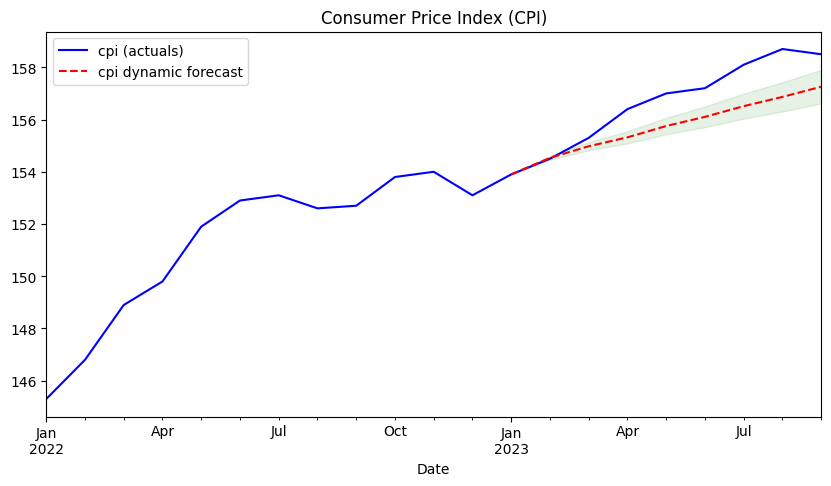

food index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0036
ARIMA(0, 0, 2) RMSE = 0.0035
ARIMA(0, 0, 3) RMSE = 0.0035
ARIMA(0, 0, 4) RMSE = 0.0035
ARIMA(0, 0, 5) RMSE = 0.0038
ARIMA(0, 0, 6) RMSE = 0.0023
ARIMA(1, 0, 0) RMSE = 0.0032
ARIMA(1, 0, 1) RMSE = 0.0033
ARIMA(1, 0, 2) RMSE = 0.0027
ARIMA(1, 0, 3) RMSE = 0.0032
ARIMA(1, 0, 4) RMSE = 0.0030
ARIMA(1, 0, 5) RMSE = 0.0034
ARIMA(1, 0, 6) RMSE = 0.0030
ARIMA(2, 0, 0) RMSE = 0.0033
ARIMA(2, 0, 1) RMSE = 0.0033
ARIMA(2, 0, 2) RMSE = 0.0034
ARIMA(2, 0, 3) RMSE = 0.0036
ARIMA(2, 0, 4) RMSE = 0.0038
ARIMA(2, 0, 5) RMSE = 0.0030
ARIMA(2, 0, 6) RMSE = 0.0027
ARIMA(3, 0, 0) RMSE = 0.0033
ARIMA(3, 0, 1) RMSE = 0.0033
ARIMA(3, 0, 2) RMSE = 0.0034
ARIMA(3, 0, 3) RMSE = 0.0035
ARIMA(3, 0, 4) RMSE = 0.0035
ARIMA(3, 0, 5) RMSE = 0.0030
ARIMA(3, 0, 6) RMSE = 0.0028
ARIMA(4, 0, 0) RMSE = 0.0030
ARIMA(4, 0, 1) RMSE = 0.0030
ARIMA(4, 0, 2) RMSE = 0.0032
ARIMA(4, 0, 3) RMSE = 0.0033
ARIMA(4, 0, 4) RMSE = 0.0033
ARIMA(4, 0, 5) RMSE = 0.0032
ARIMA(4, 0

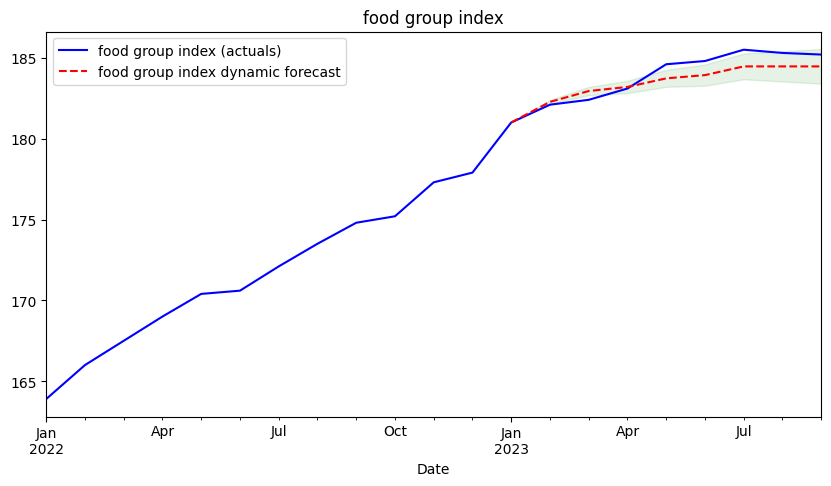

shelter index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0053
ARIMA(0, 0, 2) RMSE = 0.0053
ARIMA(0, 0, 3) RMSE = 0.0053
ARIMA(0, 0, 4) RMSE = 0.0052
ARIMA(0, 0, 5) RMSE = 0.0051
ARIMA(0, 0, 6) RMSE = 0.0048
ARIMA(1, 0, 0) RMSE = 0.0053
ARIMA(1, 0, 1) RMSE = 0.0021
ARIMA(1, 0, 2) RMSE = 0.0023
ARIMA(1, 0, 3) RMSE = 0.0024
ARIMA(1, 0, 4) RMSE = 0.0029
ARIMA(1, 0, 5) RMSE = 0.0034
ARIMA(1, 0, 6) RMSE = 0.0037
ARIMA(2, 0, 0) RMSE = 0.0051
ARIMA(2, 0, 1) RMSE = 0.0024
ARIMA(2, 0, 2) RMSE = 0.0021
ARIMA(2, 0, 3) RMSE = 0.0019
ARIMA(2, 0, 4) RMSE = 0.0023
ARIMA(2, 0, 5) RMSE = 0.0030
ARIMA(2, 0, 6) RMSE = 0.0032
ARIMA(3, 0, 0) RMSE = 0.0047
ARIMA(3, 0, 1) RMSE = 0.0048
ARIMA(3, 0, 2) RMSE = 0.0040
ARIMA(3, 0, 3) RMSE = 0.0037
ARIMA(3, 0, 4) RMSE = 0.0024
ARIMA(3, 0, 5) RMSE = 0.0027
ARIMA(3, 0, 6) RMSE = 0.0029
ARIMA(4, 0, 0) RMSE = 0.0041
ARIMA(4, 0, 1) RMSE = 0.0041
ARIMA(4, 0, 2) RMSE = 0.0024
ARIMA(4, 0, 3) RMSE = 0.0022
ARIMA(4, 0, 4) RMSE = 0.0026
ARIMA(4, 0, 5) RMSE = 0.0025
ARIMA(4

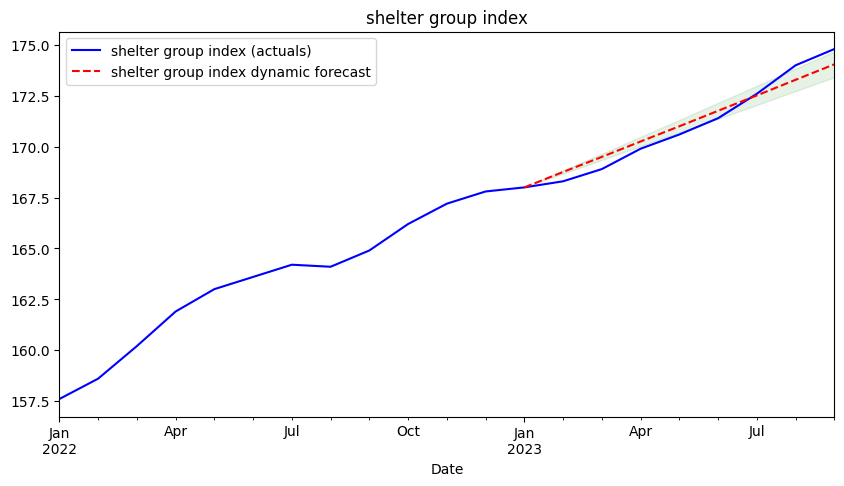

household index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0058
ARIMA(0, 0, 2) RMSE = 0.0057
ARIMA(0, 0, 3) RMSE = 0.0058
ARIMA(0, 0, 4) RMSE = 0.0058
ARIMA(0, 0, 5) RMSE = 0.0055
ARIMA(0, 0, 6) RMSE = 0.0055
ARIMA(1, 0, 0) RMSE = 0.0058
ARIMA(1, 0, 1) RMSE = 0.0057
ARIMA(1, 0, 2) RMSE = 0.0057
ARIMA(1, 0, 3) RMSE = 0.0057
ARIMA(1, 0, 4) RMSE = 0.0058
ARIMA(1, 0, 5) RMSE = 0.0056
ARIMA(1, 0, 6) RMSE = 0.0054
ARIMA(2, 0, 0) RMSE = 0.0058
ARIMA(2, 0, 1) RMSE = 0.0057
ARIMA(2, 0, 2) RMSE = 0.0057
ARIMA(2, 0, 3) RMSE = 0.0054
ARIMA(2, 0, 4) RMSE = 0.0056
ARIMA(2, 0, 5) RMSE = 0.0054
ARIMA(2, 0, 6) RMSE = 0.0053
ARIMA(3, 0, 0) RMSE = 0.0059
ARIMA(3, 0, 1) RMSE = 0.0059
ARIMA(3, 0, 2) RMSE = 0.0057
ARIMA(3, 0, 3) RMSE = 0.0057
ARIMA(3, 0, 4) RMSE = 0.0057
ARIMA(3, 0, 5) RMSE = 0.0049
ARIMA(3, 0, 6) RMSE = 0.0051
ARIMA(4, 0, 0) RMSE = 0.0059
ARIMA(4, 0, 1) RMSE = 0.0059
ARIMA(4, 0, 2) RMSE = 0.0057
ARIMA(4, 0, 3) RMSE = 0.0057
ARIMA(4, 0, 4) RMSE = 0.0058
ARIMA(4, 0, 5) RMSE = 0.0057
ARIMA

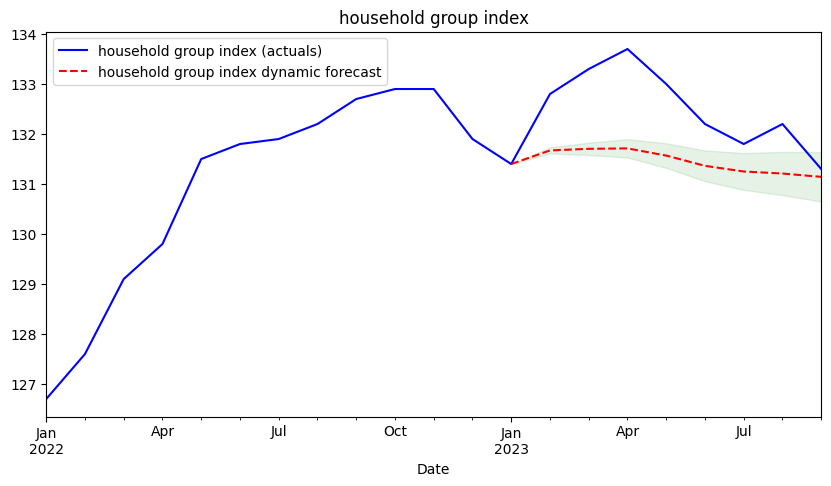

clothing index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0124
ARIMA(0, 0, 2) RMSE = 0.0102
ARIMA(0, 0, 3) RMSE = 0.0106
ARIMA(0, 0, 4) RMSE = 0.0099
ARIMA(0, 0, 5) RMSE = 0.0098
ARIMA(0, 0, 6) RMSE = 0.0084
ARIMA(1, 0, 0) RMSE = 0.0129
ARIMA(1, 0, 1) RMSE = 0.0109
ARIMA(1, 0, 2) RMSE = 0.0107
ARIMA(1, 0, 3) RMSE = 0.0105
ARIMA(1, 0, 4) RMSE = 0.0095
ARIMA(1, 0, 5) RMSE = 0.0095
ARIMA(1, 0, 6) RMSE = 0.0083
ARIMA(2, 0, 0) RMSE = 0.0103
ARIMA(2, 0, 1) RMSE = 0.0072
ARIMA(2, 0, 2) RMSE = 0.0076
ARIMA(2, 0, 3) RMSE = 0.0070
ARIMA(2, 0, 4) RMSE = 0.0064
ARIMA(2, 0, 5) RMSE = 0.0068
ARIMA(2, 0, 6) RMSE = 0.0074
ARIMA(3, 0, 0) RMSE = 0.0072
ARIMA(3, 0, 1) RMSE = 0.0067
ARIMA(3, 0, 2) RMSE = 0.0072
ARIMA(3, 0, 3) RMSE = 0.0089
ARIMA(3, 0, 4) RMSE = 0.0090
ARIMA(3, 0, 5) RMSE = 0.0068
ARIMA(3, 0, 6) RMSE = 0.0067
ARIMA(4, 0, 0) RMSE = 0.0072
ARIMA(4, 0, 1) RMSE = 0.0068
ARIMA(4, 0, 2) RMSE = 0.0065
ARIMA(4, 0, 3) RMSE = 0.0071
ARIMA(4, 0, 4) RMSE = 0.0076
ARIMA(4, 0, 5) RMSE = 0.0076
ARIMA(

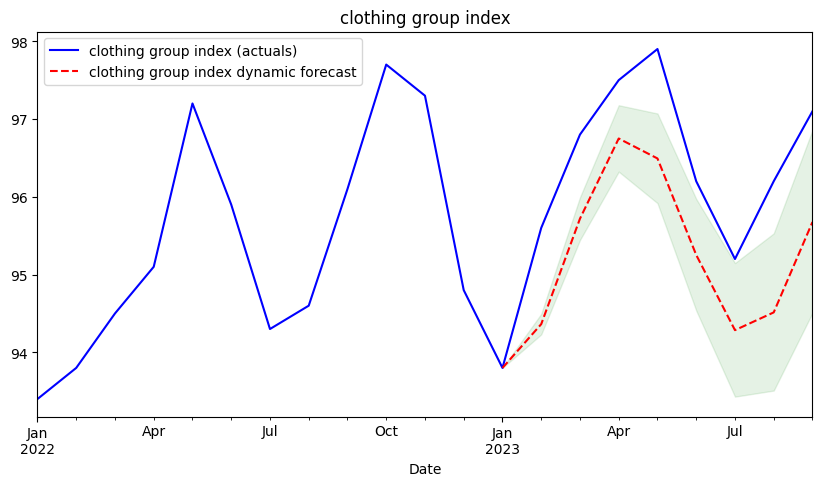

transportation index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0100
ARIMA(0, 0, 2) RMSE = 0.0100
ARIMA(0, 0, 3) RMSE = 0.0104
ARIMA(0, 0, 4) RMSE = 0.0107
ARIMA(0, 0, 5) RMSE = 0.0106
ARIMA(0, 0, 6) RMSE = 0.0113
ARIMA(1, 0, 0) RMSE = 0.0098
ARIMA(1, 0, 1) RMSE = 0.0100
ARIMA(1, 0, 2) RMSE = 0.0100
ARIMA(1, 0, 3) RMSE = 0.0100
ARIMA(1, 0, 4) RMSE = 0.0102
ARIMA(1, 0, 5) RMSE = 0.0108
ARIMA(1, 0, 6) RMSE = 0.0111
ARIMA(2, 0, 0) RMSE = 0.0101
ARIMA(2, 0, 1) RMSE = 0.0101
ARIMA(2, 0, 2) RMSE = 0.0110
ARIMA(2, 0, 3) RMSE = 0.0100
ARIMA(2, 0, 4) RMSE = 0.0105
ARIMA(2, 0, 5) RMSE = 0.0111
ARIMA(2, 0, 6) RMSE = 0.0111
ARIMA(3, 0, 0) RMSE = 0.0101
ARIMA(3, 0, 1) RMSE = 0.0101
ARIMA(3, 0, 2) RMSE = 0.0101
ARIMA(3, 0, 3) RMSE = 0.0108
ARIMA(3, 0, 4) RMSE = 0.0109
ARIMA(3, 0, 5) RMSE = 0.0110
ARIMA(3, 0, 6) RMSE = 0.0114
ARIMA(4, 0, 0) RMSE = 0.0102
ARIMA(4, 0, 1) RMSE = 0.0103
ARIMA(4, 0, 2) RMSE = 0.0109
ARIMA(4, 0, 3) RMSE = 0.0106
ARIMA(4, 0, 4) RMSE = 0.0107
ARIMA(4, 0, 5) RMSE = 0.0106


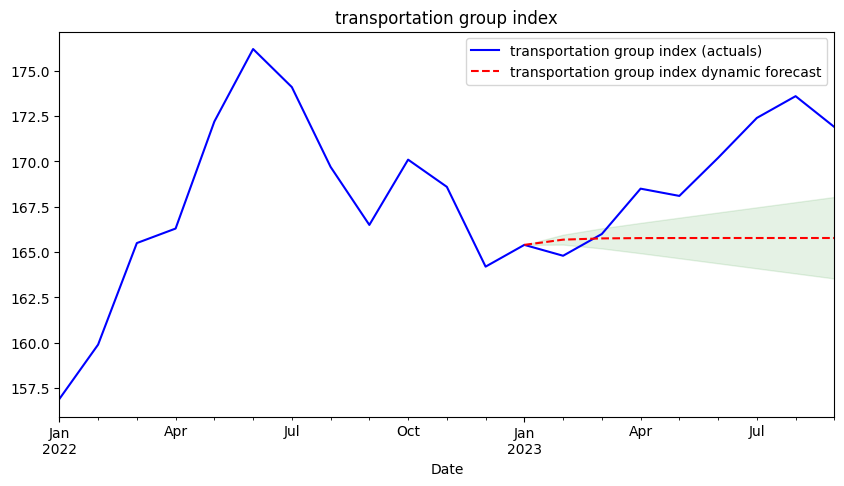

health index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0058
ARIMA(0, 0, 2) RMSE = 0.0058
ARIMA(0, 0, 3) RMSE = 0.0056
ARIMA(0, 0, 4) RMSE = 0.0055
ARIMA(0, 0, 5) RMSE = 0.0051
ARIMA(0, 0, 6) RMSE = 0.0050
ARIMA(1, 0, 0) RMSE = 0.0058
ARIMA(1, 0, 1) RMSE = 0.0057
ARIMA(1, 0, 2) RMSE = 0.0048
ARIMA(1, 0, 3) RMSE = 0.0039
ARIMA(1, 0, 4) RMSE = 0.0039
ARIMA(1, 0, 5) RMSE = 0.0038
ARIMA(1, 0, 6) RMSE = 0.0050
ARIMA(2, 0, 0) RMSE = 0.0057
ARIMA(2, 0, 1) RMSE = 0.0058
ARIMA(2, 0, 2) RMSE = 0.0040
ARIMA(2, 0, 3) RMSE = 0.0042
ARIMA(2, 0, 4) RMSE = 0.0054
ARIMA(2, 0, 5) RMSE = 0.0051
ARIMA(2, 0, 6) RMSE = 0.0043
ARIMA(3, 0, 0) RMSE = 0.0051
ARIMA(3, 0, 1) RMSE = 0.0051
ARIMA(3, 0, 2) RMSE = 0.0043
ARIMA(3, 0, 3) RMSE = 0.0058
ARIMA(3, 0, 4) RMSE = 0.0053
ARIMA(3, 0, 5) RMSE = 0.0049
ARIMA(3, 0, 6) RMSE = 0.0037
ARIMA(4, 0, 0) RMSE = 0.0049
ARIMA(4, 0, 1) RMSE = 0.0049
ARIMA(4, 0, 2) RMSE = 0.0048
ARIMA(4, 0, 3) RMSE = 0.0038
ARIMA(4, 0, 4) RMSE = 0.0046
ARIMA(4, 0, 5) RMSE = 0.0039
ARIMA(4,

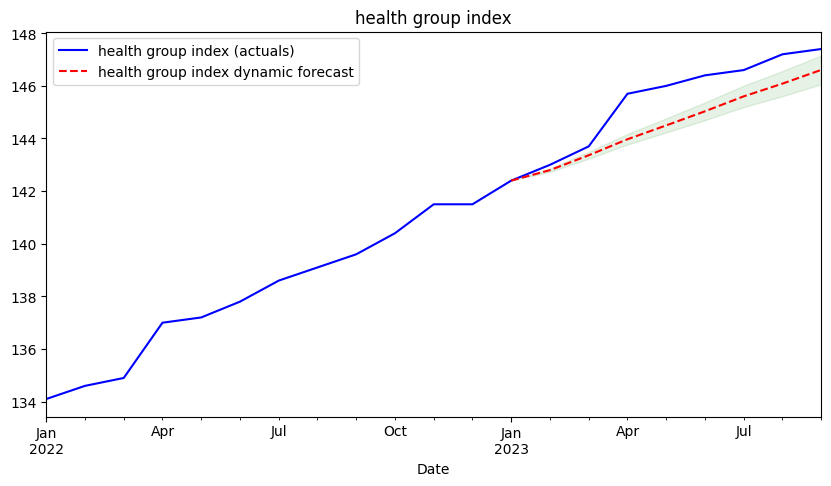

recreation index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0120
ARIMA(0, 0, 2) RMSE = 0.0120
ARIMA(0, 0, 3) RMSE = 0.0119
ARIMA(0, 0, 4) RMSE = 0.0118
ARIMA(0, 0, 5) RMSE = 0.0115
ARIMA(0, 0, 6) RMSE = 0.0120
ARIMA(1, 0, 0) RMSE = 0.0120
ARIMA(1, 0, 1) RMSE = 0.0120
ARIMA(1, 0, 2) RMSE = 0.0118
ARIMA(1, 0, 3) RMSE = 0.0121
ARIMA(1, 0, 4) RMSE = 0.0123
ARIMA(1, 0, 5) RMSE = 0.0114
ARIMA(1, 0, 6) RMSE = 0.0119
ARIMA(2, 0, 0) RMSE = 0.0121
ARIMA(2, 0, 1) RMSE = 0.0106
ARIMA(2, 0, 2) RMSE = 0.0118
ARIMA(2, 0, 3) RMSE = 0.0118
ARIMA(2, 0, 4) RMSE = 0.0120
ARIMA(2, 0, 5) RMSE = 0.0115
ARIMA(2, 0, 6) RMSE = 0.0124
ARIMA(3, 0, 0) RMSE = 0.0117
ARIMA(3, 0, 1) RMSE = 0.0117
ARIMA(3, 0, 2) RMSE = 0.0108
ARIMA(3, 0, 3) RMSE = 0.0118
ARIMA(3, 0, 4) RMSE = 0.0120
ARIMA(3, 0, 5) RMSE = 0.0116
ARIMA(3, 0, 6) RMSE = 0.0114
ARIMA(4, 0, 0) RMSE = 0.0119
ARIMA(4, 0, 1) RMSE = 0.0119
ARIMA(4, 0, 2) RMSE = 0.0116
ARIMA(4, 0, 3) RMSE = 0.0118
ARIMA(4, 0, 4) RMSE = 0.0119
ARIMA(4, 0, 5) RMSE = 0.0114
ARIM

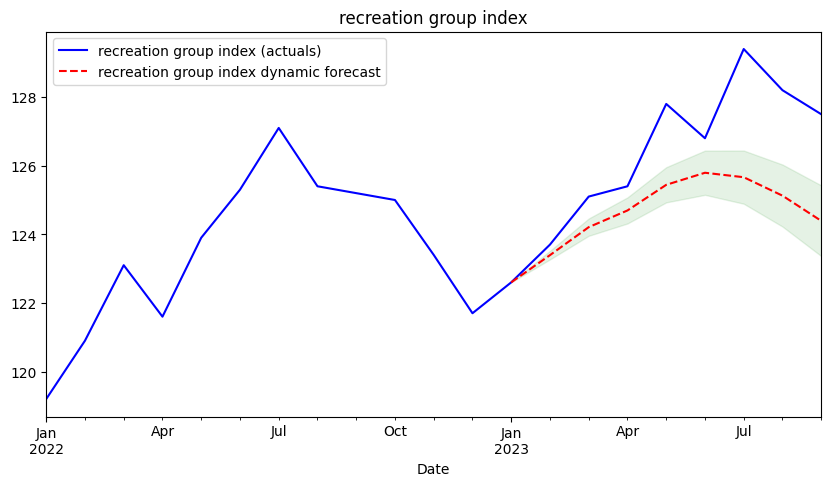

alcohol index arima model selection
ARIMA(0, 0, 1) RMSE = 0.0041
ARIMA(0, 0, 2) RMSE = 0.0037
ARIMA(0, 0, 3) RMSE = 0.0038
ARIMA(0, 0, 4) RMSE = 0.0036
ARIMA(0, 0, 5) RMSE = 0.0035
ARIMA(0, 0, 6) RMSE = 0.0035
ARIMA(1, 0, 0) RMSE = 0.0034
ARIMA(1, 0, 1) RMSE = 0.0024
ARIMA(1, 0, 2) RMSE = 0.0025
ARIMA(1, 0, 3) RMSE = 0.0027
ARIMA(1, 0, 4) RMSE = 0.0027
ARIMA(1, 0, 5) RMSE = 0.0026
ARIMA(1, 0, 6) RMSE = 0.0033
ARIMA(2, 0, 0) RMSE = 0.0029
ARIMA(2, 0, 1) RMSE = 0.0025
ARIMA(2, 0, 2) RMSE = 0.0027
ARIMA(2, 0, 3) RMSE = 0.0025
ARIMA(2, 0, 4) RMSE = 0.0028
ARIMA(2, 0, 5) RMSE = 0.0029
ARIMA(2, 0, 6) RMSE = 0.0032
ARIMA(3, 0, 0) RMSE = 0.0029
ARIMA(3, 0, 1) RMSE = 0.0030
ARIMA(3, 0, 2) RMSE = 0.0027
ARIMA(3, 0, 3) RMSE = 0.0029
ARIMA(3, 0, 4) RMSE = 0.0031
ARIMA(3, 0, 5) RMSE = 0.0025
ARIMA(3, 0, 6) RMSE = 0.0026
ARIMA(4, 0, 0) RMSE = 0.0027
ARIMA(4, 0, 1) RMSE = 0.0027
ARIMA(4, 0, 2) RMSE = 0.0027
ARIMA(4, 0, 3) RMSE = 0.0020
ARIMA(4, 0, 4) RMSE = 0.0029
ARIMA(4, 0, 5) RMSE = 0.0028
ARIMA(4

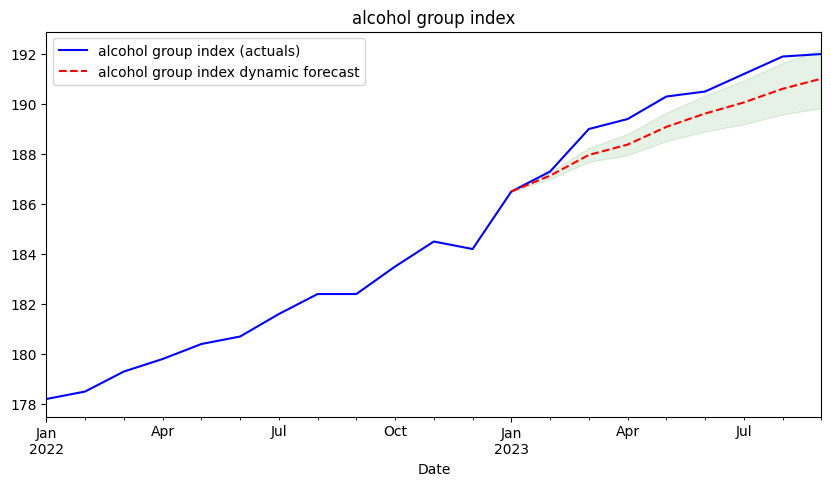

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# Define a function for date parsing
def date_parser(dates):
    return pd.to_datetime(dates, format='%d/%m/%Y')

# Load and preprocess data
def load_and_preprocess_data(cpi_csv_path, cpi_weights_csv_path):
    cpi_cad = pd.read_csv(cpi_csv_path, parse_dates=['Date'], index_col='Date', date_parser=date_parser)
    cpi_weights = pd.read_csv(cpi_weights_csv_path, parse_dates=['Date'], index_col='Date', date_parser=date_parser)

    column_mapping = {
        'All-items': 'cpi',
        'Food': 'food',
        'Shelter': 'shelter',
        'Household operations, furnishings and equipment': 'household',
        'Clothing and footwear': 'clothing',
        'Transportation': 'transportation',
        'Health and personal care': 'health',
        'Recreation, education and reading': 'recreation',
        'Alcoholic beverages, tobacco products and recreational cannabis': 'alcohol'
    }
    cpi_cad.rename(columns=column_mapping, inplace=True)
    cpi_weights.rename(columns=column_mapping, inplace=True)

    # Create log and differenced log columns using vectorized operations
    columns_to_process = ['cpi', 'food', 'shelter', 'household', 'clothing', 'transportation', 'health', 'recreation', 'alcohol']
    cpi_cad[[f'log{column}' for column in columns_to_process]] = np.log(cpi_cad[columns_to_process] + 1e-10)
    cpi_cad[[f'dlog{column}' for column in columns_to_process]] = cpi_cad[[f'log{column}' for column in columns_to_process]].diff()

    return cpi_cad, cpi_weights

# Load and preprocess the data
# Statistics Canada
# https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000401
cpi_csv_path = '/content/drive/MyDrive/ .... /CPI_CAD_20231018.csv'
# Basket weights of the Consumer Price Index, Canada
# https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000701
cpi_weights_csv_path = '/content/drive/MyDrive/ .... /CPI_CAD_Weights_2021_2022.csv'
cpi_cad, cpi_weights = load_and_preprocess_data(cpi_csv_path, cpi_weights_csv_path)

# Define a function for ARIMA model evaluation
def arima_model_evaluate(actuals, validation, order):
    sarimax_model = SARIMAX(actuals, order=order).fit()
    prediction = sarimax_model.get_forecast(len(validation))
    predictions_df = prediction.conf_int()
    predictions_df["Predictions"] = sarimax_model.predict(start=predictions_df.index[0], end=predictions_df.index[-1])
    predictions_df.index = validation.index
    predictions_arima = predictions_df["Predictions"]
    rmse_score = rmse(validation, predictions_df["Predictions"])
    return rmse_score

# Define a function to optimize ARIMA model parameters
def optimize_arima(actuals, validation, p_values, d_values, q_values):
    best_rmse, best_config = float("inf"), None
    parameter_combinations = [(p, d, q) for p in p_values for d in d_values for q in q_values]
    for order in parameter_combinations:
        rmse_score = arima_model_evaluate(actuals, validation, order)
        if order == (0, 0, 0):
            continue
        elif rmse_score < best_rmse:
            best_rmse, best_config = rmse_score, order
        print(f'ARIMA{order} RMSE = {rmse_score:.4f}')
    print(f'Best Configuration: ARIMA{best_config}, RMSE = {best_rmse:.4f}')
    return best_config

# Train ARIMA model and get best configuration
t = 8
cpi_cad_train = cpi_cad.iloc[:-t]
cpi_cad_validation = cpi_cad.iloc[-t:]
p_values = range(0, 7)
d_values = range(0, 1)
q_values = range(0, 7)

variables = ['cpi', 'food', 'shelter', 'household', 'clothing', 'transportation', 'health', 'recreation', 'alcohol']
for var in variables:
    actuals = cpi_cad_train[f'dlog{var}'].dropna()
    validation = cpi_cad_validation[f'dlog{var}'].dropna()
    print(f'{var} index arima model selection')
    best_config = optimize_arima(actuals, validation, p_values, d_values, q_values)
    order = best_config
    # Train the final ARIMA model with the best configuration
    sarimax_model = SARIMAX(actuals, order=order).fit()
    prediction = sarimax_model.get_forecast(len(validation))
    predictions_df = prediction.conf_int(alpha=0.9)
    predictions_df['Predictions'] = sarimax_model.predict(start=predictions_df.index[0], end=predictions_df.index[-1])
    predictions_df.index = validation.index

    # Combine forecasted columns in the original DataFrame
    cpi_cad[f'dlog{var}_pred_m'] = predictions_df['Predictions']
    cpi_cad[f'log{var}pred_m'] = np.nan
    for i in range(t):
        if i == 0:
            cpi_cad[f'log{var}pred_m'].iloc[-t] = cpi_cad[f'log{var}'].iloc[-t-1] + cpi_cad[f'dlog{var}_pred_m'].iloc[-t]
        else:
            cpi_cad[f'log{var}pred_m'].iloc[-t+i] = cpi_cad[f'log{var}pred_m'].iloc[-t+i-1] + cpi_cad[f'dlog{var}_pred_m'].iloc[-t+i]
    cpi_cad[f'{var}pred'] = np.exp(cpi_cad[f'log{var}pred_m'])
    cpi_cad[f'{var}pred'].iloc[-t-1] = cpi_cad[f'{var}'].iloc[-t-1]

    cpi_cad[f'dlog{var}_pred_u'] = predictions_df[f'upper dlog{var}']
    cpi_cad[f'log{var}pred_u'] = np.nan
    for i in range(t):
        if i == 0:
            cpi_cad[f'log{var}pred_u'].iloc[-t] = cpi_cad[f'log{var}'].iloc[-t-1] + cpi_cad[f'dlog{var}_pred_u'].iloc[-t]
        else:
            cpi_cad[f'log{var}pred_u'].iloc[-t+i] = cpi_cad[f'log{var}pred_u'].iloc[-t+i-1] + cpi_cad[f'dlog{var}_pred_u'].iloc[-t+i]
    cpi_cad[f'{var}pred_upperbound'] = np.exp(cpi_cad[f'log{var}pred_u'])
    cpi_cad[f'{var}pred_upperbound'].iloc[-t-1] = cpi_cad[f'{var}'].iloc[-t-1]

    cpi_cad[f'dlog{var}_pred_l'] = predictions_df[f'lower dlog{var}']
    cpi_cad[f'log{var}pred_l'] = np.nan
    for i in range(t):
        if i == 0:
            cpi_cad[f'log{var}pred_l'].iloc[-t] = cpi_cad[f'log{var}'].iloc[-t-1] + cpi_cad[f'dlog{var}_pred_l'].iloc[-t]
        else:
            cpi_cad[f'log{var}pred_l'].iloc[-t+i] = cpi_cad[f'log{var}pred_l'].iloc[-t+i-1] + cpi_cad[f'dlog{var}_pred_l'].iloc[-t+i]
    cpi_cad[f'{var}pred_lowerbound'] = np.exp(cpi_cad[f'log{var}pred_l'])
    cpi_cad[f'{var}pred_lowerbound'].iloc[-t-1] = cpi_cad[f'{var}'].iloc[-t-1]


    # Plot the chart
    if var == 'cpi':
        cpi_cad_chart = cpi_cad.iloc[-21:]
        fig, ax = plt.subplots(figsize=(10, 5))
        cpi_cad_chart[f'{var}'].plot(ax=ax, style='b', label=f'{var} (actuals)')
        cpi_cad_chart[f'{var}pred'].plot(ax=ax, style='r--', label=f'{var} dynamic forecast')
        ax.fill_between(cpi_cad_chart.index, cpi_cad_chart[f'{var}pred_upperbound'], cpi_cad_chart[f'{var}pred_lowerbound'], color='g', alpha=0.1)
        plt.title('Consumer Price Index (CPI)')
        plt.legend()
        plt.show()
    else:
        cpi_cad_chart = cpi_cad.iloc[-21:]
        fig, ax = plt.subplots(figsize=(10, 5))
        cpi_cad_chart[f'{var}'].plot(ax=ax, style='b', label=f'{var} group index (actuals)')
        cpi_cad_chart[f'{var}pred'].plot(ax=ax, style='r--', label=f'{var} group index dynamic forecast')
        ax.fill_between(cpi_cad_chart.index, cpi_cad_chart[f'{var}pred_upperbound'], cpi_cad_chart[f'{var}pred_lowerbound'], color='g', alpha=0.1)
        plt.title(f'{var} group index')
        plt.legend()
        plt.show()

In [ ]:
prediction_matrix = cpi_cad.loc[:, ['foodpred', 'shelterpred', 'householdpred', 'clothingpred', 'transportationpred', 'healthpred', 'recreationpred', 'alcoholpred']]
prediction_matrix_ub = cpi_cad.loc[:, ['foodpred_upperbound', 'shelterpred_upperbound', 'householdpred_upperbound', 'clothingpred_upperbound', 'transportationpred_upperbound', 'healthpred_upperbound', 'recreationpred_upperbound', 'alcoholpred_upperbound']]
prediction_matrix_lb = cpi_cad.loc[:, ['foodpred_lowerbound', 'shelterpred_lowerbound', 'householdpred_lowerbound', 'clothingpred_lowerbound', 'transportationpred_lowerbound', 'healthpred_lowerbound', 'recreationpred_lowerbound', 'alcoholpred_lowerbound']]
prediction_matrix = prediction_matrix.iloc[-t-1: , :]
prediction_matrix_ub = prediction_matrix_ub.iloc[-t-1: , :]
prediction_matrix_lb = prediction_matrix_lb.iloc[-t-1: , :]
cpi_weights = cpi_weights.iloc[-t-1: , :]

In [ ]:
prediction_matrix

,foodpred,shelterpred,householdpred,clothingpred,transportationpred,healthpred,recreationpred,alcoholpred
Date,,,,,,,,
2023-01-01,181.000000,168.000000,131.400000,93.800000,165.400000,142.400000,122.600000,186.500000
2023-02-01,182.273052,168.759197,131.671452,94.362791,165.688295,142.798174,123.393500,187.134631
2023-03-01,182.943933,169.499021,131.704030,95.719065,165.757319,143.362356,124.208767,187.962697
2023-04-01,183.197568,170.255537,131.712854,96.749600,165.773831,143.971719,124.695293,188.376994
2023-05-01,183.727357,171.002818,131.568930,96.492970,165.777781,144.497670,125.442281,189.086080
2023-06-01,183.928434,171.764956,131.363866,95.252178,165.778725,145.033619,125.793895,189.618385
2023-07-01,184.466506,172.519614,131.250421,94.285483,165.778951,145.601163,125.664012,190.063424
2023-08-01,184.466506,173.287554,131.209893,94.513813,165.779005,146.085433,125.126365,190.608682
2023-09-01,184.466506,174.049531,131.143248,95.675718,165.779018,146.606789,124.392329,191.014645


In [ ]:
prediction_matrix['cpi_aggregate_predict'] = np.nan
prediction_matrix['cpi_aggregate_predict_ec'] = np.nan
prediction_matrix['cpi_aggregate_predict'] = (prediction_matrix['foodpred'] * cpi_weights['food'] / 100) + (prediction_matrix['shelterpred'] * cpi_weights['shelter']/100) + (prediction_matrix['householdpred'] * cpi_weights['household']/100) + (prediction_matrix['clothingpred'] * cpi_weights['clothing']/ 100) + (prediction_matrix['transportationpred'] * cpi_weights['transportation']/100) + (prediction_matrix['healthpred'] * cpi_weights['health']/100) + (prediction_matrix['recreationpred'] * cpi_weights['recreation']/100) + (prediction_matrix['alcoholpred'] * cpi_weights['alcohol']/100)
weights_error_correction = cpi_cad['cpi']['2022-12-01'] / prediction_matrix['cpi_aggregate_predict'].iloc[0]
prediction_matrix['cpi_aggregate_predict_ec'].iloc[1:] = prediction_matrix['cpi_aggregate_predict'].iloc[1:] * weights_error_correction
cpi_cad = pd.concat([cpi_cad, prediction_matrix], axis = 1)

prediction_matrix_ub['cpi_aggregate_predict_ub'] = np.nan
prediction_matrix_ub['cpi_aggregate_predict_ub_ec'] = np.nan
prediction_matrix_ub['cpi_aggregate_predict_ub'] = (prediction_matrix_ub['foodpred_upperbound'] * cpi_weights['food'] / 100) + (prediction_matrix_ub['shelterpred_upperbound'] * cpi_weights['shelter']/100) + (prediction_matrix_ub['householdpred_upperbound'] * cpi_weights['household']/100) + (prediction_matrix_ub['clothingpred_upperbound'] * cpi_weights['clothing']/ 100) + (prediction_matrix_ub['transportationpred_upperbound'] * cpi_weights['transportation']/100) + (prediction_matrix_ub['healthpred_upperbound'] * cpi_weights['health']/100) + (prediction_matrix_ub['recreationpred_upperbound'] * cpi_weights['recreation']/100) + (prediction_matrix_ub['alcoholpred_upperbound'] * cpi_weights['alcohol']/100)
weights_error_correction = cpi_cad['cpi']['2022-12-01'] / prediction_matrix_ub['cpi_aggregate_predict_ub'].iloc[0]
prediction_matrix_ub['cpi_aggregate_predict_ub_ec'].iloc[1:] = prediction_matrix_ub['cpi_aggregate_predict_ub'].iloc[1:] * weights_error_correction
cpi_cad = pd.concat([cpi_cad, prediction_matrix_ub], axis = 1)

prediction_matrix_lb['cpi_aggregate_predict_lb'] = np.nan
prediction_matrix_lb['cpi_aggregate_predict_lb_ec'] = np.nan
prediction_matrix_lb['cpi_aggregate_predict_lb'] = (prediction_matrix_lb['foodpred_lowerbound'] * cpi_weights['food'] / 100) + (prediction_matrix_lb['shelterpred_lowerbound'] * cpi_weights['shelter']/100) + (prediction_matrix_lb['householdpred_lowerbound'] * cpi_weights['household']/100) + (prediction_matrix_lb['clothingpred_lowerbound'] * cpi_weights['clothing']/ 100) + (prediction_matrix_lb['transportationpred_lowerbound'] * cpi_weights['transportation']/100) + (prediction_matrix_lb['healthpred_lowerbound'] * cpi_weights['health']/100) + (prediction_matrix_lb['recreationpred_lowerbound'] * cpi_weights['recreation']/100) + (prediction_matrix_lb['alcoholpred_lowerbound'] * cpi_weights['alcohol']/100)
weights_error_correction = cpi_cad['cpi']['2022-12-01'] / prediction_matrix_lb['cpi_aggregate_predict_lb'].iloc[0]
prediction_matrix_lb['cpi_aggregate_predict_lb_ec'].iloc[1:] = prediction_matrix_lb['cpi_aggregate_predict_lb'].iloc[1:] * weights_error_correction
cpi_cad = pd.concat([cpi_cad, prediction_matrix_lb], axis = 1)

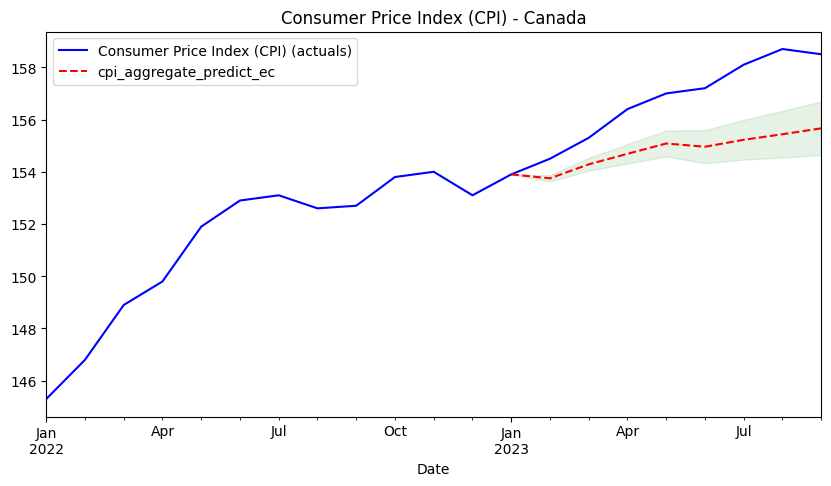

In [ ]:
cpi_cad['cpi_aggregate_predict_ec'].iloc[-t-1] = cpi_cad['cpi'].iloc[-t-1]
cpi_cad['cpi_aggregate_predict_ub_ec'].iloc[-t-1] = cpi_cad['cpi'].iloc[-t-1]
cpi_cad['cpi_aggregate_predict_lb_ec'].iloc[-t-1] = cpi_cad['cpi'].iloc[-t-1]
# Plot the chart
cpi_cad_chart = cpi_cad.iloc[-21:]
fig, ax = plt.subplots(figsize=(10, 5))
cpi_cad_chart['cpi'].plot(ax=ax, style='b', label='Consumer Price Index (CPI) (actuals)')
cpi_cad_chart['cpi_aggregate_predict_ec'].plot(ax=ax, style='r--', label='cpi_aggregate_predict_ec')
ax.fill_between(cpi_cad_chart.index, cpi_cad_chart['cpi_aggregate_predict_ub_ec'], cpi_cad_chart['cpi_aggregate_predict_lb_ec'], color='g', alpha=0.1)
plt.title('Consumer Price Index (CPI) - Canada')
plt.legend()
plt.show()

In [ ]:
cpi_cad.tail(10)

,cpi,food,shelter,household,clothing,transportation,Gasoline,health,recreation,alcohol,...,foodpred_lowerbound,shelterpred_lowerbound,householdpred_lowerbound,clothingpred_lowerbound,transportationpred_lowerbound,healthpred_lowerbound,recreationpred_lowerbound,alcoholpred_lowerbound,cpi_aggregate_predict_lb,cpi_aggregate_predict_lb_ec
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-01,153.1,177.9,167.8,131.9,94.8,164.2,208.3,141.5,121.7,184.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-01,153.9,181.0,168.0,131.4,93.8,165.4,218.1,142.4,122.6,186.5,...,181.000000,168.000000,131.400000,93.800000,165.400000,142.400000,122.600000,186.500000,156.175890,153.900000
2023-02-01,154.5,182.1,168.3,132.8,95.6,164.8,215.9,143.0,123.7,187.3,...,182.150997,168.682676,131.610169,94.230610,165.414827,142.734218,123.268695,186.996561,156.716058,153.629529
2023-03-01,155.3,182.4,168.9,133.3,96.8,166.0,218.4,143.7,125.1,189.0,...,182.689860,169.345288,131.581420,95.444851,165.202910,143.231011,123.956846,187.683715,157.135872,154.041075
2023-04-01,156.4,183.1,169.9,133.7,97.5,168.5,232.2,145.7,125.4,189.4,...,182.809605,170.023557,131.528822,96.323429,164.938556,143.772332,124.315648,187.953467,157.417898,154.317547
2023-05-01,157.0,184.6,170.6,133.0,97.9,168.1,230.3,146.0,127.8,190.3,...,183.204299,170.691838,131.323332,95.918223,164.662121,144.229855,124.930729,188.515969,157.692046,154.586295
2023-06-01,157.2,184.8,171.4,132.2,96.2,170.2,234.7,146.4,126.8,190.5,...,183.270639,171.373944,131.056983,94.537269,164.383167,144.696876,125.150777,188.898653,157.427123,154.326590
2023-07-01,158.1,185.5,172.6,131.8,95.2,172.4,236.8,146.6,129.4,191.2,...,183.671843,172.047800,130.881602,93.430764,164.103975,145.194423,124.891534,189.192566,157.568116,154.464806
2023-08-01,158.7,185.3,174.0,132.2,96.2,173.6,247.8,147.2,128.2,191.9,...,183.534549,172.733907,130.778573,93.508685,163.825087,145.608211,124.225875,189.584693,157.652505,154.547533


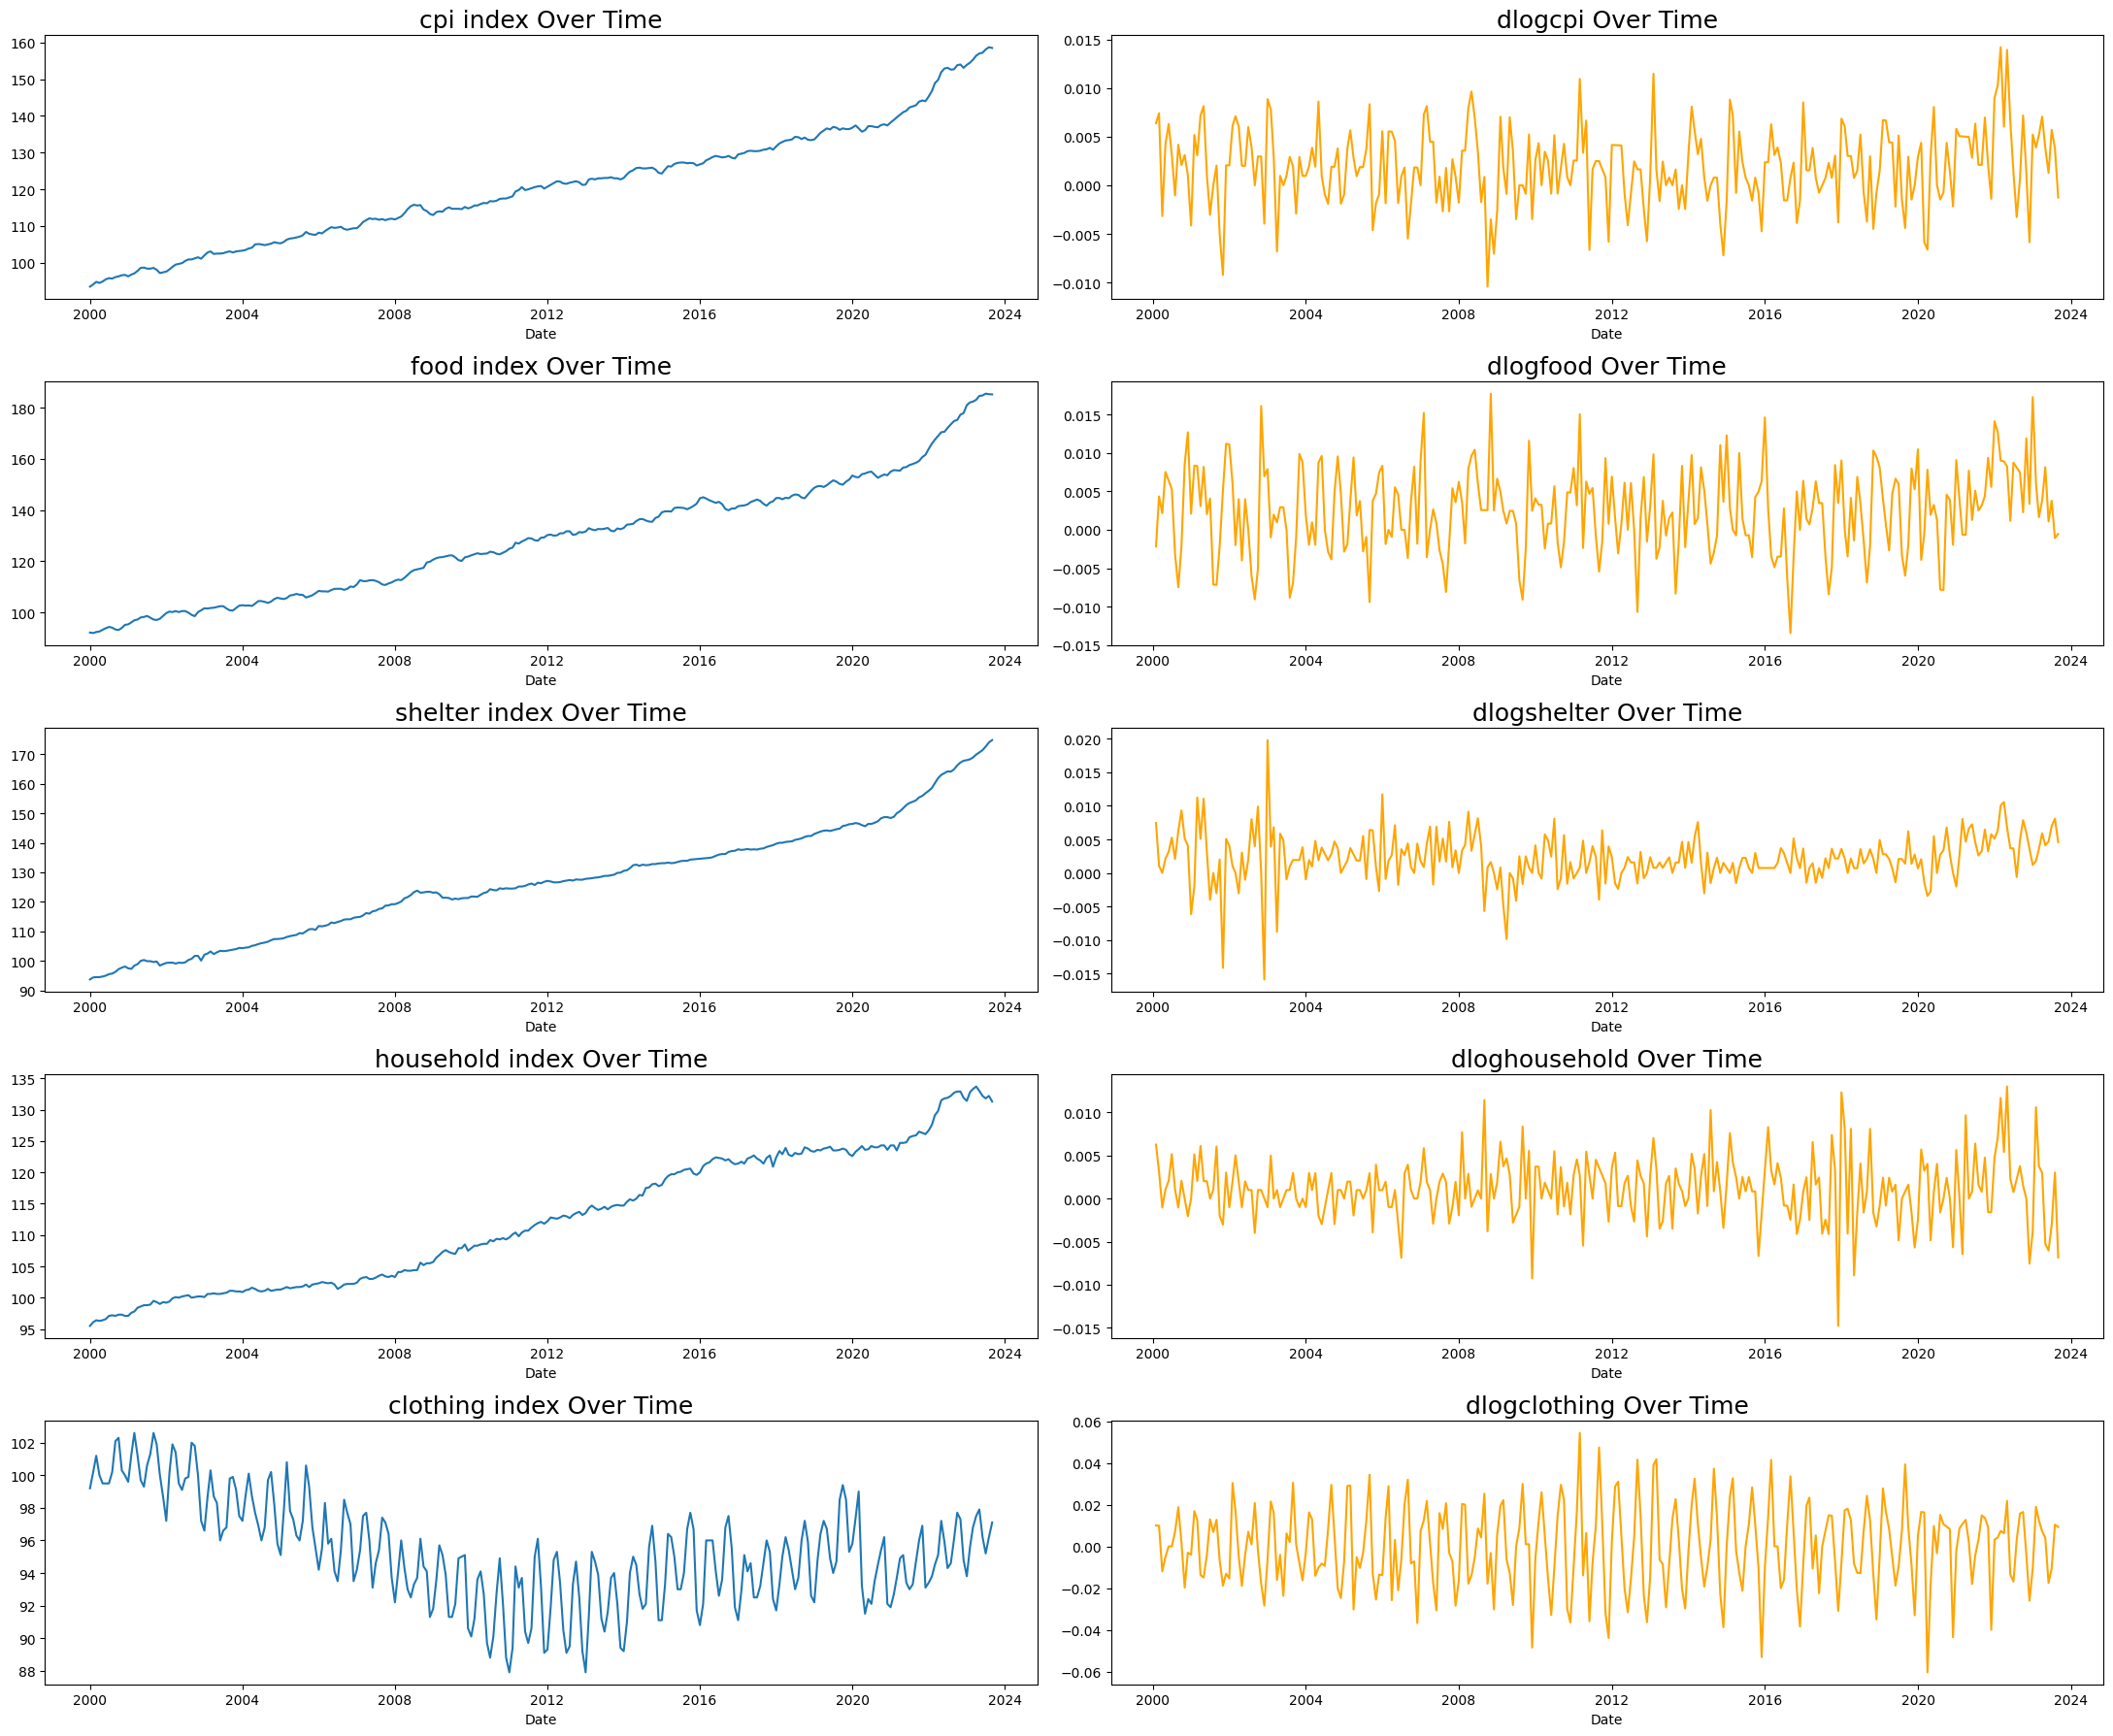

In [ ]:
columns = ['cpi', 'food', 'shelter', 'household', 'clothing']
# Plot each variable in separate subplots within a single large plot
fig, axes = plt.subplots(len(columns), 2, figsize=(22, 18))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(columns):
    # Plot log(col) in the left subplot
    axes[i, 0].plot(cpi_cad.index, cpi_cad[f'{col}'], label=f'{col}')
    axes[i, 0].set_title(f'{col} index Over Time', fontsize=18)
    axes[i, 0].set_xlabel('Date')
    #axes[i, 0].set_ylabel(f'{col}')

    # Plot dlog(col) in the right subplot
    axes[i, 1].plot(cpi_cad.index, cpi_cad[f'dlog{col}'], label=f'dlog{col}', color='orange')
    axes[i, 1].set_title(f'dlog{col} Over Time', fontsize=18)
    axes[i, 1].set_xlabel('Date')
    #axes[i, 1].set_ylabel(f'dlog{col}')

plt.tight_layout()
plt.show()

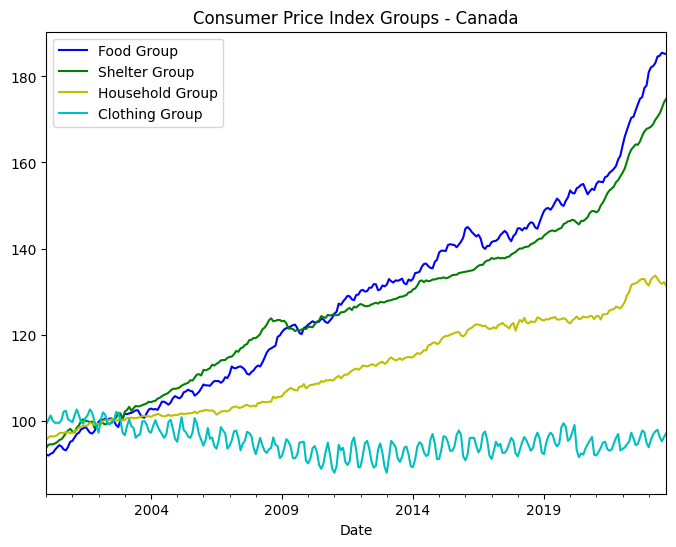

In [ ]:
# Plot the chart
fig, ax = plt.subplots(figsize=(8, 6))
cpi_cad_chart = cpi_cad.iloc[0:]
#plt.figure(figsize=(12, 6))
cpi_cad_chart['food'].plot(ax=ax, style='b', label='Food Group')
cpi_cad_chart['shelter'].plot(ax=ax, style='g', label='Shelter Group')
cpi_cad_chart['household'].plot(ax=ax, style='y', label='Household Group')
cpi_cad_chart['clothing'].plot(ax=ax, style='c', label='Clothing Group')
plt.title('Consumer Price Index Groups - Canada')
plt.legend()
plt.show()

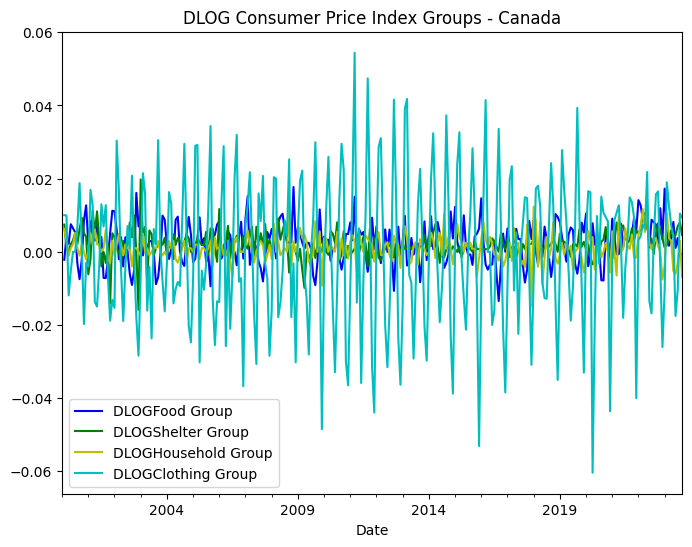

In [ ]:
# Plot the chart
fig, ax = plt.subplots(figsize=(8, 6))
cpi_cad_chart = cpi_cad.iloc[0:]
#plt.figure(figsize=(12, 6))
cpi_cad_chart['dlogfood'].plot(ax=ax, style='b', label='DLOGFood Group')
cpi_cad_chart['dlogshelter'].plot(ax=ax, style='g', label='DLOGShelter Group')
cpi_cad_chart['dloghousehold'].plot(ax=ax, style='y', label='DLOGHousehold Group')
cpi_cad_chart['dlogclothing'].plot(ax=ax, style='c', label='DLOGClothing Group')
plt.title('DLOG Consumer Price Index Groups - Canada')
plt.legend()
plt.show()

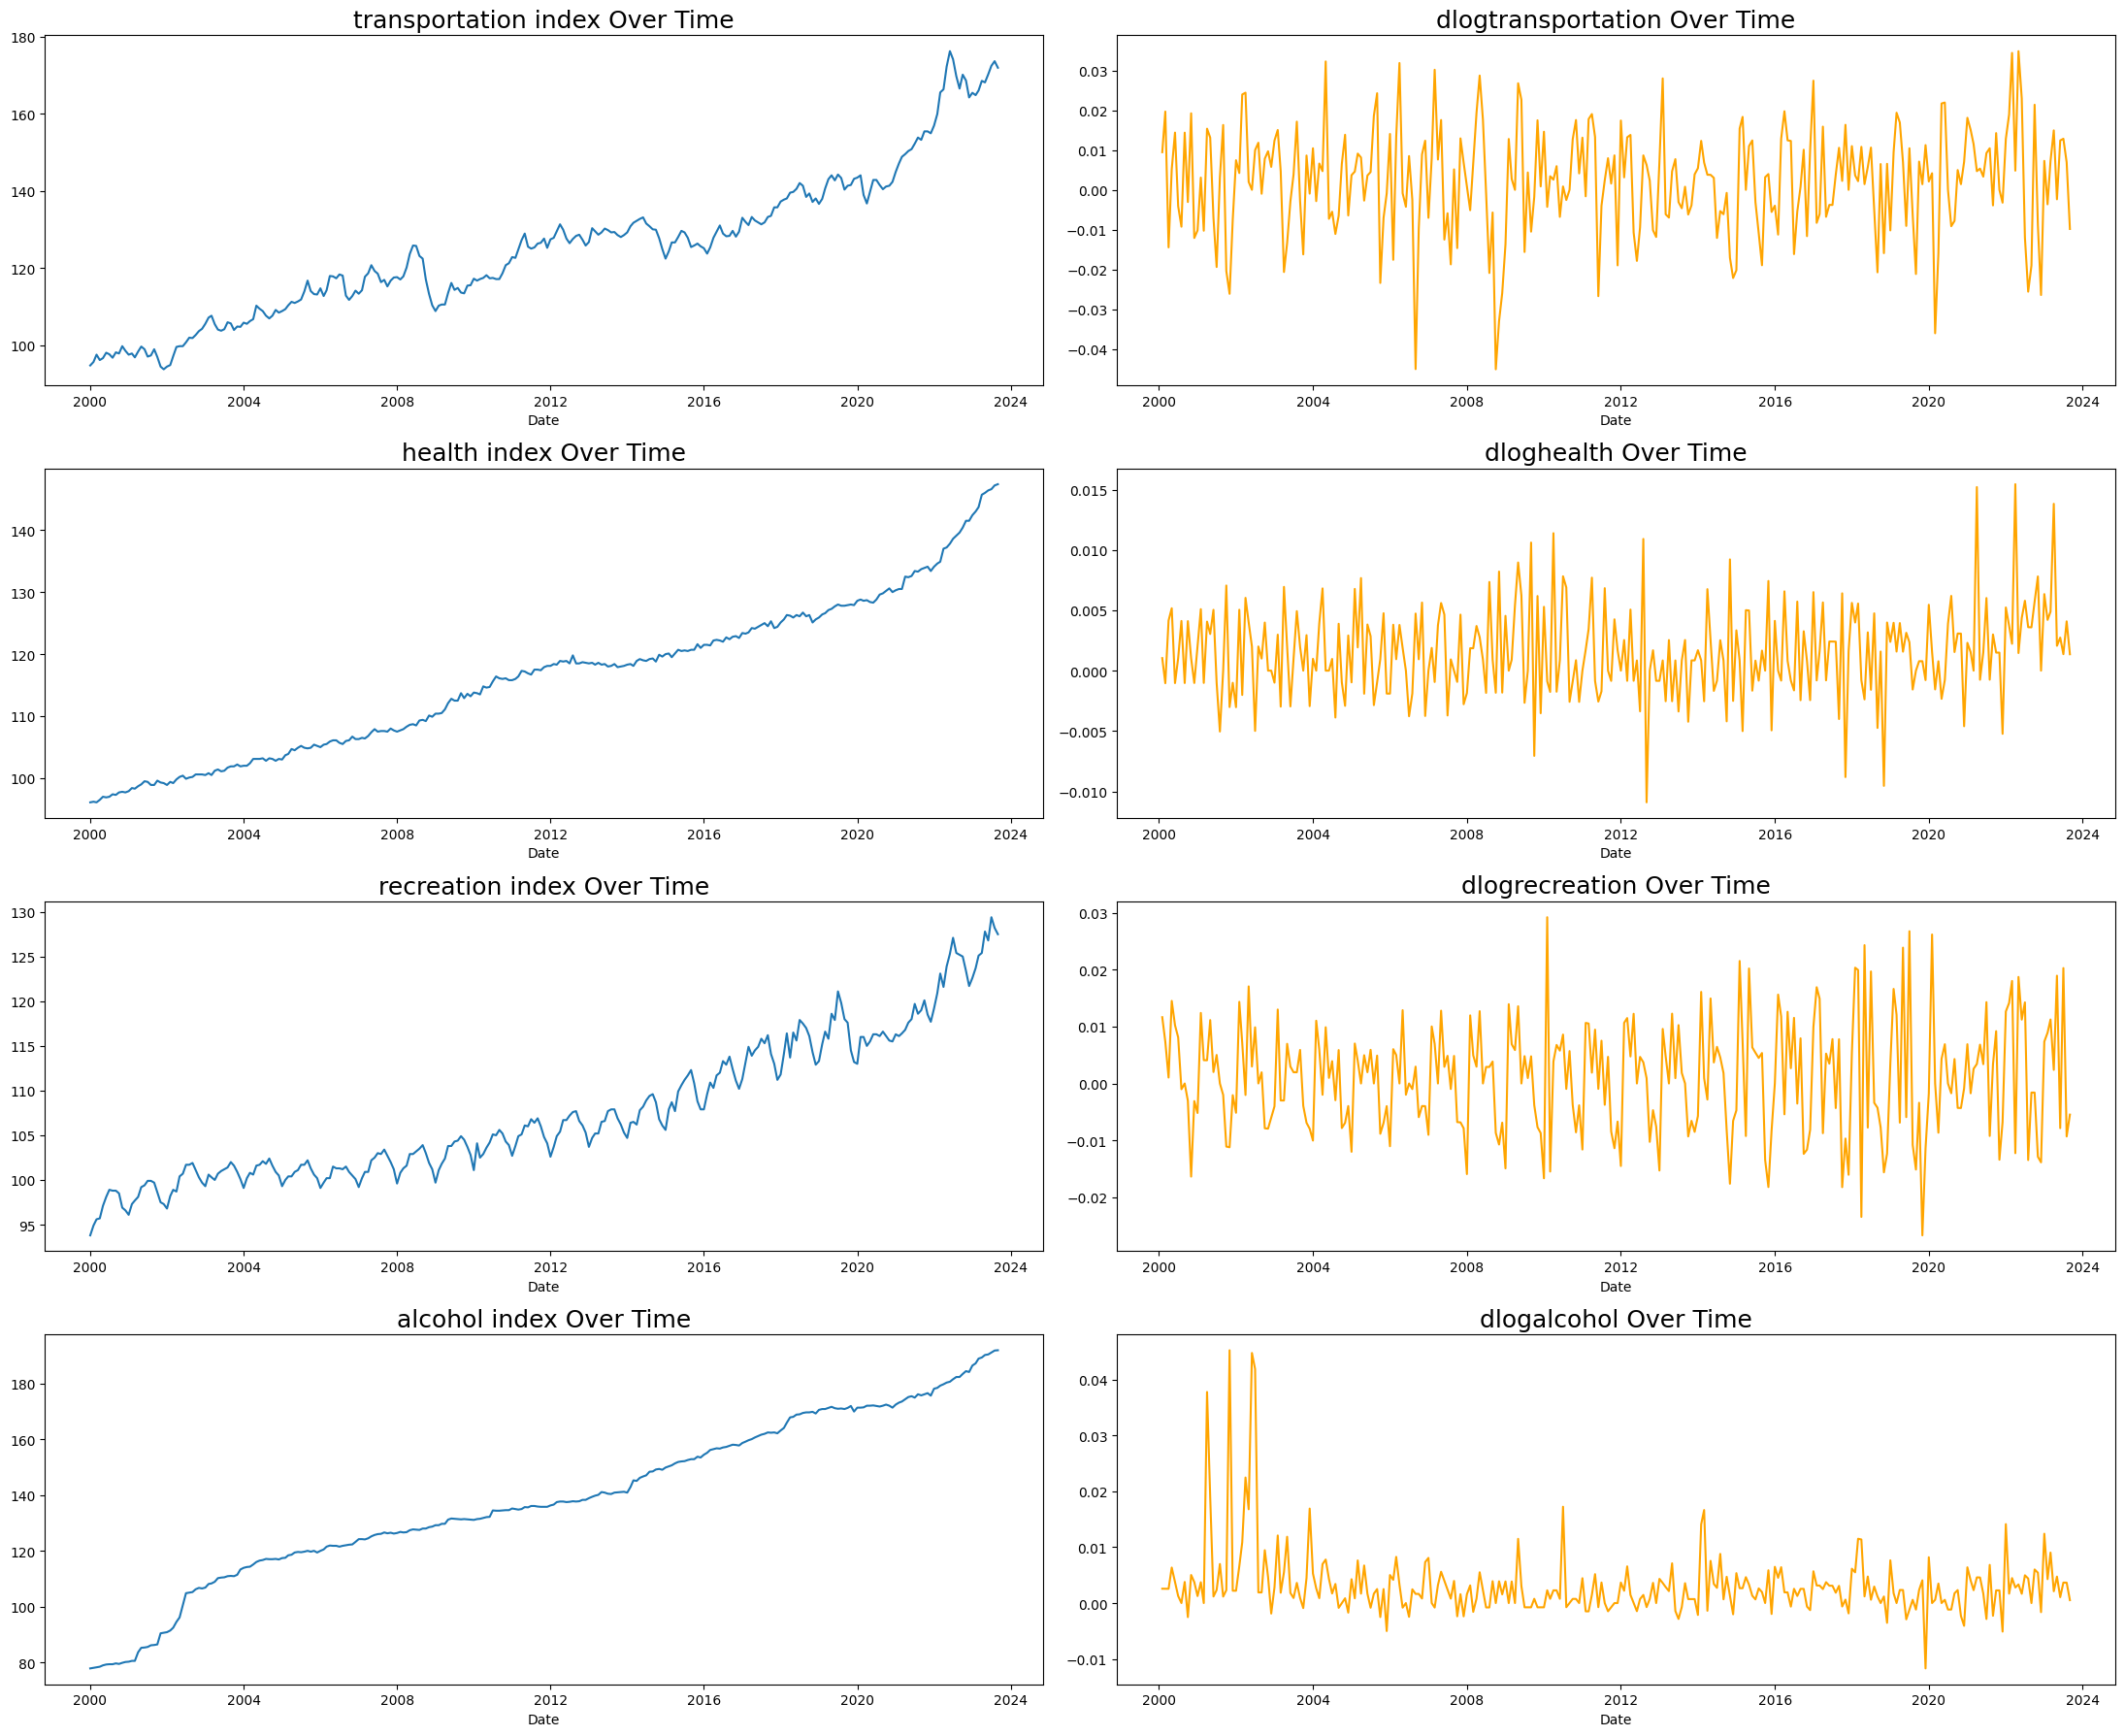

In [ ]:
columns = ['transportation', 'health', 'recreation', 'alcohol']
# Plot each variable in separate subplots within a single large plot
fig, axes = plt.subplots(len(columns), 2, figsize=(22, 18))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(columns):
    # Plot log(col) in the left subplot
    axes[i, 0].plot(cpi_cad.index, cpi_cad[f'{col}'], label=f'{col}')
    axes[i, 0].set_title(f'{col} index Over Time', fontsize=18)
    axes[i, 0].set_xlabel('Date')
    #axes[i, 0].set_ylabel(f'{col}')

    # Plot dlog(col) in the right subplot
    axes[i, 1].plot(cpi_cad.index, cpi_cad[f'dlog{col}'], label=f'dlog{col}', color='orange')
    axes[i, 1].set_title(f'dlog{col} Over Time', fontsize=18)
    axes[i, 1].set_xlabel('Date')
    #axes[i, 1].set_ylabel(f'dlog{col}')

plt.tight_layout()
plt.show()

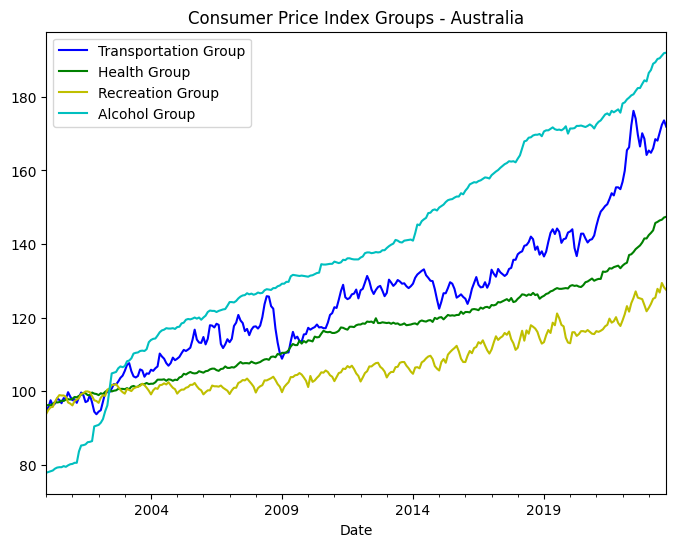

In [ ]:
# Plot the chart
fig, ax = plt.subplots(figsize=(8, 6))
cpi_cad_chart = cpi_cad.iloc[0:]
#plt.figure(figsize=(12, 6))
cpi_cad_chart['transportation'].plot(ax=ax, style='b', label='Transportation Group')
cpi_cad_chart['health'].plot(ax=ax, style='g', label='Health Group')
cpi_cad_chart['recreation'].plot(ax=ax, style='y', label='Recreation Group')
cpi_cad_chart['alcohol'].plot(ax=ax, style='c', label='Alcohol Group')
plt.title('Consumer Price Index Groups - Australia')
plt.legend()
plt.show()

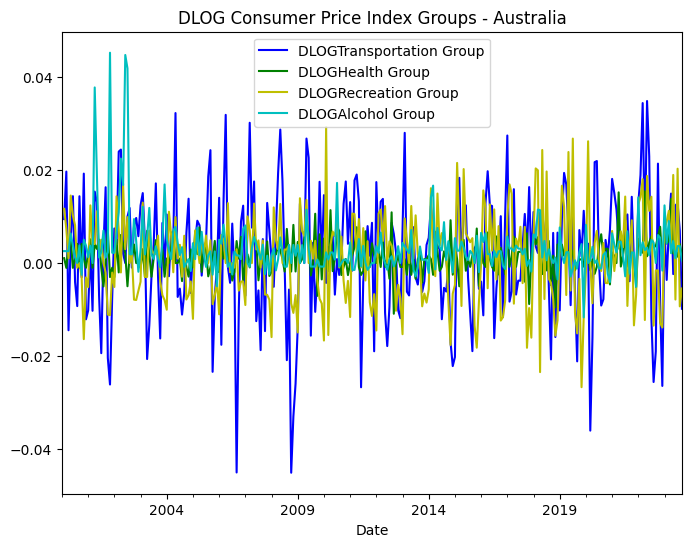

In [ ]:
# Plot the chart
fig, ax = plt.subplots(figsize=(8, 6))
cpi_cad_chart = cpi_cad.iloc[0:]
#plt.figure(figsize=(12, 6))
cpi_cad_chart['dlogtransportation'].plot(ax=ax, style='b', label='DLOGTransportation Group')
cpi_cad_chart['dloghealth'].plot(ax=ax, style='g', label='DLOGHealth Group')
cpi_cad_chart['dlogrecreation'].plot(ax=ax, style='y', label='DLOGRecreation Group')
cpi_cad_chart['dlogalcohol'].plot(ax=ax, style='c', label='DLOGAlcohol Group')
plt.title('DLOG Consumer Price Index Groups - Australia')
plt.legend()
plt.show()